Fitting 5 folds for each of 12 candidates, totalling 60 fits

Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}

Test Accuracy: 0.9750

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       100
           1       0.97      0.96      0.96       100
           2       0.96      0.97      0.97       100
           3       0.98      0.99      0.99       100

    accuracy                           0.97       400
   macro avg       0.98      0.98      0.97       400
weighted avg       0.98      0.97      0.97       400



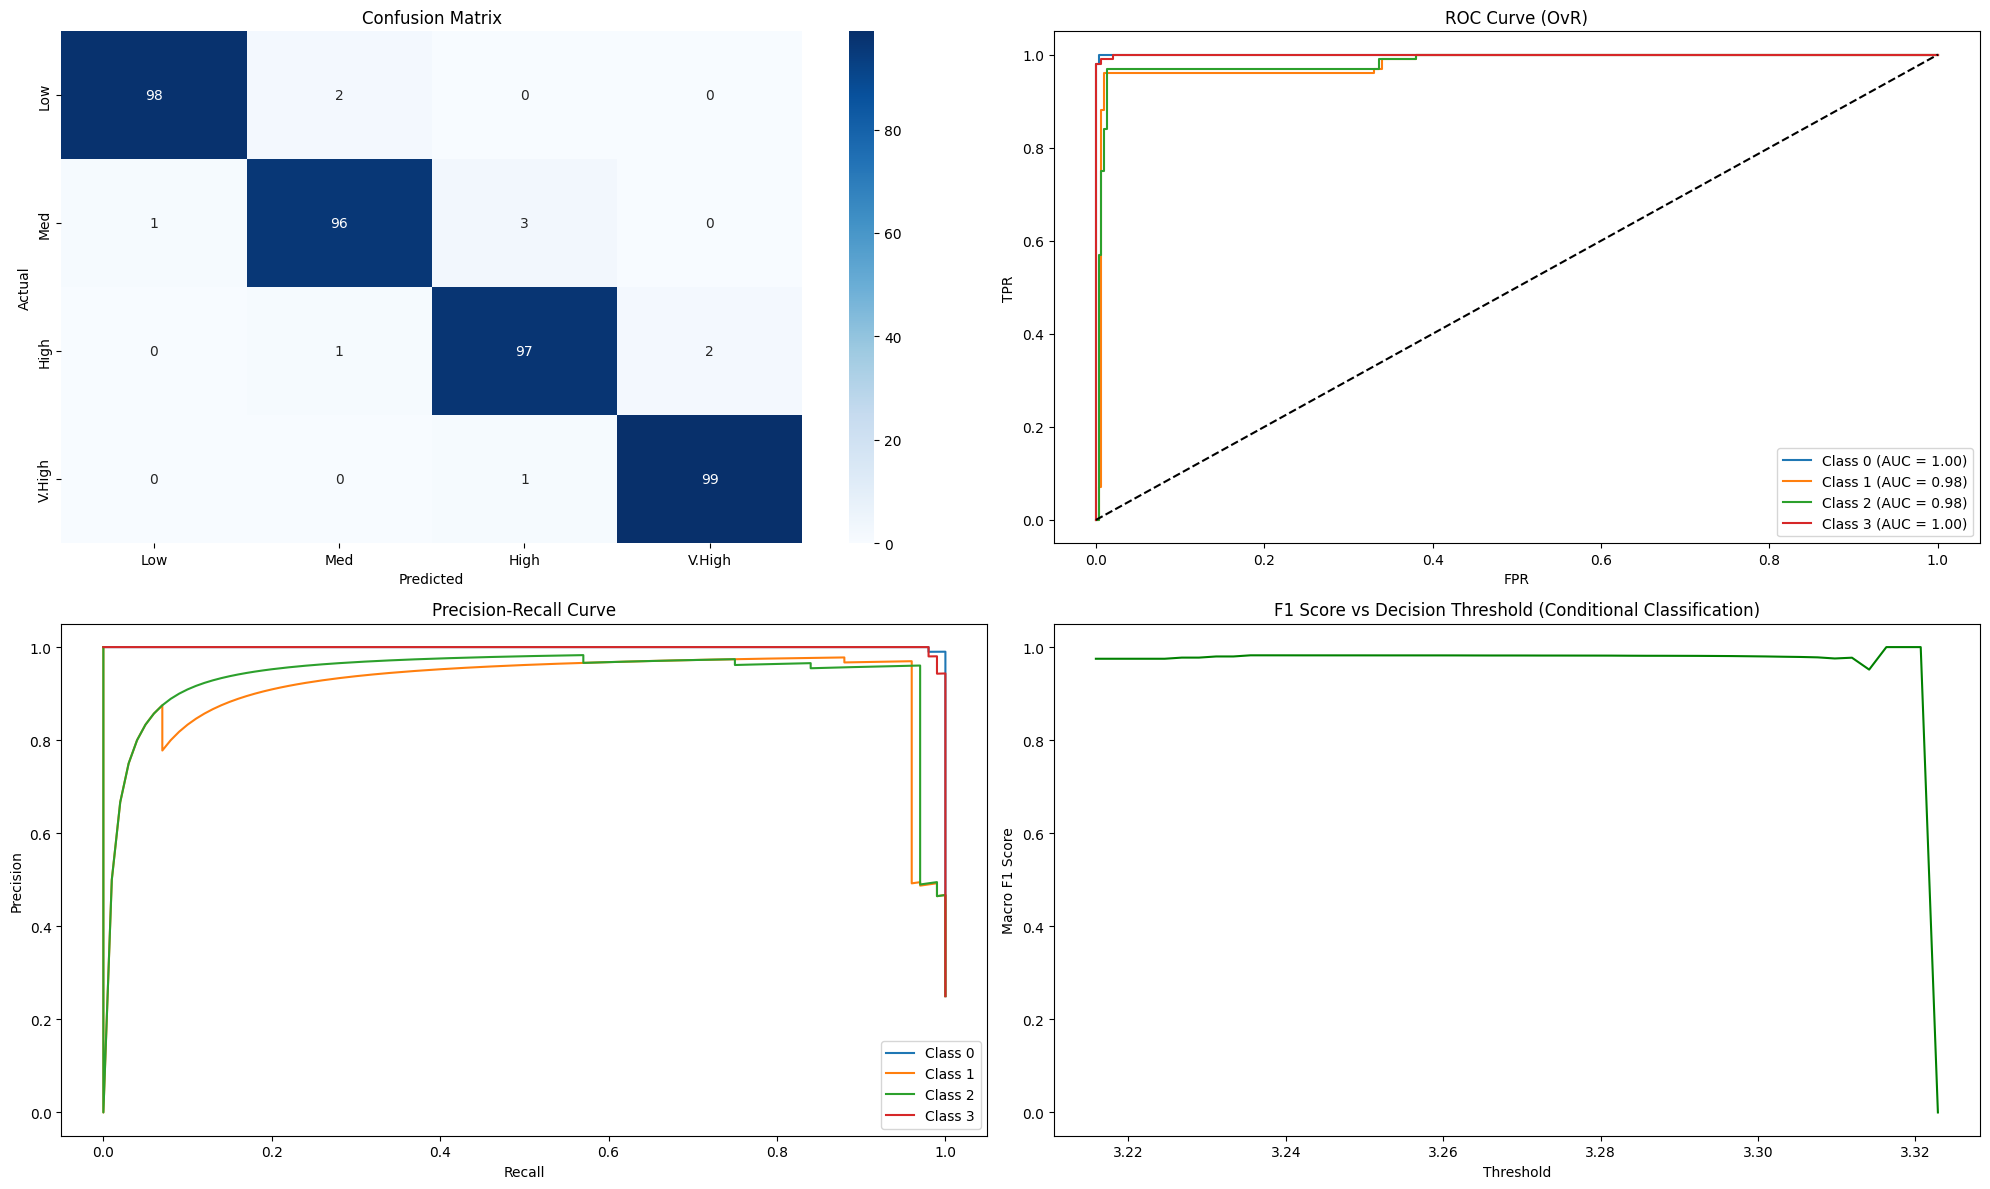

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.svm import SVC
from sklearn.metrics import (accuracy_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve, average_precision_score, f1_score)

# 1. Load Dataset directly (Ensures no FileNotFoundError in Colab)
url = "https://raw.githubusercontent.com/amankharwal/Website-data/master/mobile_prices.csv"
df = pd.read_csv(url)

# 2. Features and Target Setup
X = df.drop('price_range', axis=1)
y = df['price_range']
n_classes = len(np.unique(y)) # Total of 4 classes (0, 1, 2, 3)

# 3. Data Preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Scaling is mandatory for SVM to prevent large features (RAM) from dominating
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 4. Hyperparameter Tuning
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.01],
    'kernel': ['linear', 'rbf']
}

# probability=True allows for ROC and PR curve calculations
svm = SVC(probability=True, random_state=42)
grid = GridSearchCV(svm, param_grid, cv=5, n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

svm_model = grid.best_estimator_
print(f"\nBest Parameters: {grid.best_params_}")

# 5. Model Evaluation
y_pred = svm_model.predict(X_test_scaled)
y_score = svm_model.decision_function(X_test_scaled) # For curves
y_test_binarized = label_binarize(y_test, classes=[0, 1, 2, 3])

print(f"\nTest Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# --- VISUALIZATIONS ---
plt.figure(figsize=(20, 12))

# A. Confusion Matrix
plt.subplot(2, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Med', 'High', 'V.High'],
            yticklabels=['Low', 'Med', 'High', 'V.High'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

# B. Multi-class ROC Curve (One-vs-Rest)
plt.subplot(2, 2, 2)
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC Curve (OvR)')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend()

# C. Multi-class Precision-Recall Curve
plt.subplot(2, 2, 3)
for i in range(n_classes):
    prec, rec, _ = precision_recall_curve(y_test_binarized[:, i], y_score[:, i])
    plt.plot(rec, prec, label=f'Class {i}')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()

# D. F1 Score vs Threshold (Macro Average)
plt.subplot(2, 2, 4)

# Calculate predicted classes and max decision scores once outside the loop
predicted_classes_all = np.argmax(y_score, axis=1)
max_decision_scores_all = np.max(y_score, axis=1)

# Determine threshold range based on max decision scores
min_score = max_decision_scores_all.min()
max_score = max_decision_scores_all.max()
thresholds = np.linspace(min_score, max_score, 50)

f1_results = []
for t in thresholds:
    # Classify based on the highest score only if it passes the threshold, otherwise mark as -1
    y_pred_t_conditional = np.where(max_decision_scores_all > t, predicted_classes_all, -1)

    # Identify valid indices where a prediction was made (not -1)
    valid_indices = y_pred_t_conditional != -1

    # Handle cases where no samples meet the threshold
    if np.sum(valid_indices) == 0:
        f1_results.append(0.0)
        continue

    # Calculate F1 score only for classified samples
    f1 = f1_score(y_test[valid_indices], y_pred_t_conditional[valid_indices], average='macro', zero_division=0)
    f1_results.append(f1)

plt.plot(thresholds, f1_results, color='green')
plt.title('F1 Score vs Decision Threshold (Conditional Classification)')
plt.xlabel('Threshold')
plt.ylabel('Macro F1 Score')

plt.tight_layout()
plt.show()